# Assignment 2 - Search

In this assignment, you are going to complete the implementation of a state representation for the Traveling Salesman Problem and perform several simulations of simulated annealing.

What you need to do:
<br>1. Follow the instructions and complete the parts with **# TODO**.
<br>2. Complete the implementations. 
<br>3. Run experiments to search for the best setting of parameters **k** and **lam**.
<br>4. Report the results using tables.
<br>5. Discuss your findings.

# Your Information

### Note -- my own functions and methods are in `helper.py`.

In [1]:
import helper
from   helper import *

# Implementations

**TODO**: Complete the implementation of `TSPNode` and `read_TSP_from_file`. See below.

In [2]:
class Node:
    def __init__(self, state, parent = None):
        self.state = state
        self.parent = parent

    def __repr__(self):
        return "Node: {}".format(self.state)

    def path(self):
        current = self
        path_back = [current]
        while current.parent is not None:
            path_back.append(current.parent)
            current = current.parent
        return reversed(path_back)

    def expand(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

In [3]:
class TSPNode(Node):
    _random_state = None
    _distances   = None

    def __init__(self, state, parent = None):
        """
        A state is an ordered list of cities. For e.g., ["A", "C", "D", "B"].
        This represents the solution of A - C - D - B - A.
        """        
        super().__init__(state, parent)
    
    def __repr__(self):
        return "Node: <{}> {:.1f}".format(" ".join(self.state), self.value())
    
    def expand(self):
        """
        Generate one random neighbor using the TSPNode._random_state.
        
        The random neighbor should be generated as follows. Pick two cities at random, and swap them.
        
        return:

        [neighbor_node]: a list of one TSPNode whose parent is this node.
        """''
        two_random    = random.sample(self.state, 2)
        current_state = list(self.state)
        new_state     = current_state.copy()
        index_1 = current_state.index(two_random[0])
        index_2 = current_state.index(two_random[1])
        new_state[index_1] = two_random[1]
        new_state[index_2] = two_random[0]
        neigbhor_node = TSPNode(state = new_state)
        return [neigbhor_node]
    
    def value(self):
        """
        Calculate the total cost.
        
        return:
        -1*total_distance: the total cost of current state
        
        """
        total_distance = 0
        n = len(self.state)

        for i in range(n):
            from_c = self.state[i]
            if i == n-1:
                to_c = self.state[0]
            else:
                to_c = self.state[i+1]
            
            total_distance += TSPNode._distances[from_c][to_c]

        return -1*total_distance

In [4]:
class Graph:
    def __init__(self):
        self.distances = defaultdict(dict)

    def add_edge(self, from_c, to_c, dist):
        self.distances[from_c][to_c] = dist
        self.distances[to_c][from_c] = dist

In [5]:
def make_graph(city_coords, dist_mat):
    """
    Create a graph for the given TSP
    
    param:
    city_coords: dictionary of cities
    dist_mat: distance matrix
    
    return:
    graph: an instance of Graph class that saved all necessary edges and costs
    
    """
    graph = Graph()

    cities = list(city_coords.keys())

    for i in range(len(cities)-1):
        from_c = cities[i]
        for j in range(i+1, len(cities)):
            to_c = cities[j]
            dist = dist_mat[i][j]
            graph.add_edge(from_c, to_c, dist)
    return graph

In [6]:
def init_state(seed, city_coords):
    """
    Create an initial state node 
    
    param:
    seed: random seed
    city_coords: dictionary of cities
    
    return:
    initial_state: an instance of TSPNode class with a randomly generated state
    
    """
    rand_state = np.random.RandomState(seed=seed)
    
    cities         = list(city_coords.keys())
    shuffle_cities = list(rand_state.permutation(cities))
    initial_state  = TSPNode(shuffle_cities)
    return initial_state

In [7]:
def exp_schedule(k, lam):
    """
    The exponential schedule function for simulated annealing
    
    param:
    k: initial temperature
    lam: cooling factor lam
    
    return:
    a function that accepts the current number of iteration as input and outputs a new temperature
    
    """
    return lambda t: k * np.exp(-lam * t) 

def linear_schedule(k, lam):
    return lambda t: max(0, k - lam*t)


def log_schedule(k, lam):
    return lambda t: k / (1+lam*np.log(t+1))

In [8]:
def simulated_annealing(initial_n, temp_schedule, max_iter, random_state):
    """
    Simulated annealing algorithm
    
    param:
    initial_n: initial state
    temp_schedule: temperature schedule function
    max_iter: the max number of iterations
    random_state: random state used to select random node or generate probability
    
    return:
    current_n: an instance of TSPNode as solution state
    
    """
    current_n = initial_n
    for t in range(max_iter):
        
        T = temp_schedule(t)
        next_nodes = current_n.expand()

        if len(next_nodes) == 0:
            return current_n
        else:
            next_n  = random_state.choice(next_nodes)

            delta_e =  next_n.value() - current_n.value()

            if delta_e > 0:
                current_n = next_n
            else:
                p = np.exp(delta_e/T)
                if random_state.random() < p:
                    current_n = next_n
    return current_n

In [9]:
def check_margin(x, y, x_inner_lim, y_inner_lim):
    if x < x_inner_lim[0]:
        return True
    elif x > x_inner_lim[1]:
        return True
    elif x_inner_lim[0] <= x <= x_inner_lim[1] and (y > y_inner_lim[1] or y < y_inner_lim[0]):
        return True
    else:
        return False

In [10]:
def TSP_generator(seed, x_inner_lim, x_outer_lim, y_inner_lim, y_outer_lim, num_city):
    i = 0
    cities = set()
    dist_mat = np.zeros((num_city, num_city))

    # Generate cities
    while len(cities) < num_city:
        rand_state = np.random.RandomState(seed=seed + i)
        x_coord = rand_state.uniform(x_outer_lim[0], x_outer_lim[1], num_city)
        y_coord = rand_state.uniform(y_outer_lim[0], y_outer_lim[1], num_city)

        # Check if the generated coordinates are in the inner area
        new_set = [(x, y) for x, y in zip(x_coord, y_coord) if check_margin(x, y, x_inner_lim, y_inner_lim)]
        cities.update(new_set)
        i += 1

    cities = list(cities)[:num_city]
    cities_dict = dict(zip(string.ascii_uppercase, cities))

    # Generate edge cost
    coordinates = np.asarray(cities)
    for i in range(num_city):
        for j in range(i + 1, num_city):
            dist_mat[i][j] = np.sqrt(np.sum((coordinates[i] - coordinates[j]) ** 2))
    return cities_dict, dist_mat

In [11]:
def TSP_plot(city_coords):
    pylab.rcParams['figure.figsize'] = (10.0, 8.0)

    for k_name, v_coord in city_coords.items():
        x, y = v_coord
        plt.scatter(x, y, marker='x', c='r', s=100)
        plt.text(x, y + 0.04, k_name, fontsize='xx-large')
    plt.show()

In [12]:
def solution_visualization(solution, city_coords):
    """
    Visualize the final solution
    
    param:
    solution: a TSPNode of final state
    city_coords: dictionary of cities
    
    """
    pylab.rcParams['figure.figsize'] = (10.0, 8.0)
    
    for k_name, v_coord in city_coords.items():
        x, y = v_coord
        plt.scatter(x, y, marker='x', c='r', s=100)
        plt.text(x, y+0.04, k_name, fontsize='xx-large')
        
    # Draw the line between two cities
    for i, c in enumerate(solution.state):
        x_start, y_start = city_coords[c]
        if i != len(solution.state) - 1:
            x_end, y_end = city_coords[solution.state[i+1]]
        else:
            x_end, y_end = city_coords[solution.state[0]]
        
        x, y = [x_start, x_end], [y_start, y_end]
        x_mid, y_mid = (x_start + x_end)/2, (y_start + y_end)/2
        plt.plot(x, y, 'ro-')

    plt.show()

In [13]:
def read_TSP_from_file():
    """
    Read cities from file
    
    return:
    city_coords: a Dictionary as {city_name: (x_coordinate, y_coordinate)}
    dist_mat: a matrix of euclidean distance between each pair of cities
    
    """
    keep = []
    f = open('berlin52.tsp', 'r')
    keep_bool = False
    x = f.readlines()
    city_coords = {}
    for item in x:
        if 'EOF' in item:
            keep_bool = False
        if keep_bool == True:
            [city, coord_1, coord_2] = item.strip().split(' ')
            city_coords[city] = (float(coord_1),float(coord_2))
            keep.append(item)
        if 'NODE_COORD_SECTION' in item:
            keep_bool = True
    f.close()
    coords = list(city_coords.values())
    dist_mat = np.zeros((len(coords), len(coords)))
    for i in range(len(coords)):
        for j in range(len(coords)):
            c1, c2 = coords[i], coords[j]
            dist_mat[i][j] = np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

    
    return city_coords, dist_mat

# Testing your implementation

## Generate or read a TSP problem

In [14]:
rand_seed  = 11
rand_state = np.random.RandomState(rand_seed)

In [15]:
x_inner_range, x_outer_range = (-99, 99), (-100, 100)
y_inner_range, y_outer_range = (-99, 99), (-100, 100)

num_city     = 10
max_iter     = 1000
schedule_k   = 500
schedule_lam = 0.25

In [16]:
cities_coords_1, dist_mat_1 = TSP_generator(rand_seed, x_inner_range, x_outer_range,
                                                   y_inner_range, y_outer_range, num_city)

In [17]:
cities_coords_1

{'A': (99.13890417289295, 90.71933136600211),
 'B': (99.29114501781939, 34.36131251541505),
 'C': (-99.29089063805382, 76.46810625333362),
 'D': (99.31484603092986, 11.991420744425014),
 'E': (-94.06859823501537, 99.39149259753762),
 'F': (-27.35708069579421, -99.52680499115773),
 'G': (99.97345852477585, 41.93031251762548),
 'H': (69.21701945617659, 99.22516370932331),
 'I': (-97.08500750291607, -99.54815329629729),
 'J': (3.4595767693178487, -99.50702375982277)}

In [18]:
display(dist_mat_1)

array([[  0.        ,  56.35822448, 198.94089797,  78.72810722,
        193.40203041, 228.46187119,  48.79615601,  31.1073684 ,
        273.32314068, 212.93332261],
       [  0.        ,   0.        , 202.99706147,  22.36990433,
        204.00224173, 184.29813099,   7.59969162,  71.4966588 ,
        237.68748035, 164.6342034 ],
       [  0.        ,   0.        ,   0.        , 208.80967797,
         23.51072052, 190.12806683, 202.23535804, 170.03764121,
        176.03008137, 203.77660547],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        212.2167031 , 168.766382  ,  29.94613516,  92.28003617,
        225.86274382, 147.0378719 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 209.80685329, 202.37121092, 163.28570241,
        198.96251263, 221.52283117],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , 190.32388792, 220.972627  ,
         69.72793008,  30.81666381],
       [  

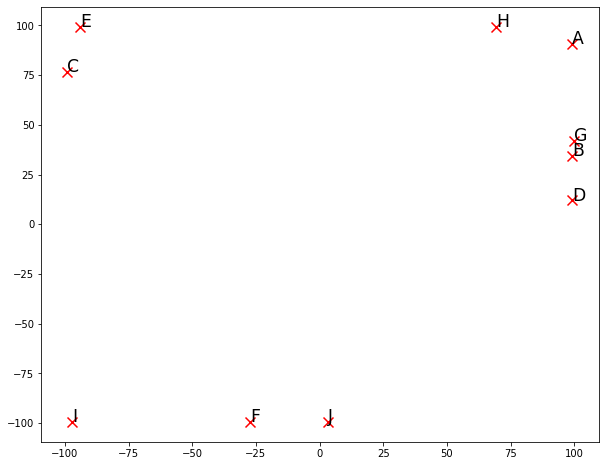

In [19]:
TSP_plot(cities_coords_1)

In [20]:
tsp_graph             = make_graph(cities_coords_1, dist_mat_1)
TSPNode._distances    = tsp_graph.distances
TSPNode._random_state = rand_state

## 2. Generate initial state

In [21]:
initial_n_1 = init_state(rand_seed, cities_coords_1)
initial_n_1.state

['H', 'I', 'C', 'G', 'E', 'F', 'B', 'D', 'A', 'J']

## 3. Run Simulated Annealing

In [22]:
t_schedule = exp_schedule(k=schedule_k, lam=schedule_lam)

In [23]:
solution_n = simulated_annealing(initial_n_1, t_schedule, max_iter, rand_state)
solution_n.state

['F', 'J', 'D', 'B', 'G', 'A', 'H', 'E', 'C', 'I']

In [24]:
sol_path = list(solution_n.path())
for node in sol_path:
    print(node)

Node: <F J D B G A H E C I> -720.3


## 4. Visualize final solution

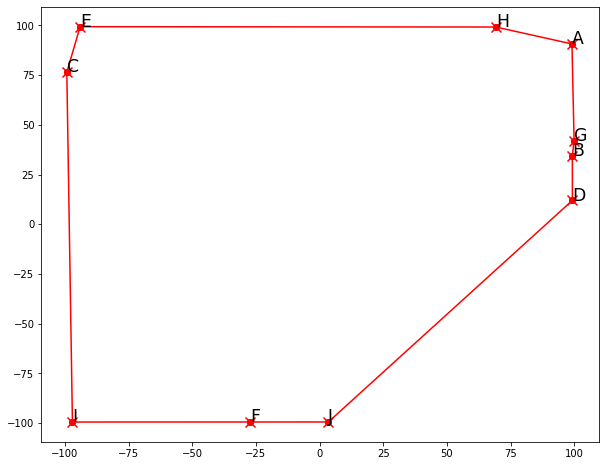

In [25]:
solution_visualization(solution_n, cities_coords_1)

# Run Simulations

## TSP-1 (Large cost)

The TSP problem generated with large costs. Please use the given random seed. 

In [26]:
num_city = 10
x_inner_range, x_outer_range = (-900, 900), (-1000, 1000)
y_inner_range, y_outer_range = (-900, 900), (-1000, 1000)

cities_coords_2, dist_mat_2 = TSP_generator(1234, x_inner_range, x_outer_range,
                                            y_inner_range, y_outer_range, num_city)
tsp_graph_2 = make_graph(cities_coords_2, dist_mat_2)
TSPNode._distances = tsp_graph_2.distances

### Brute Force

Optimal result: Node: <A I H E F C B G J D> -6467.9


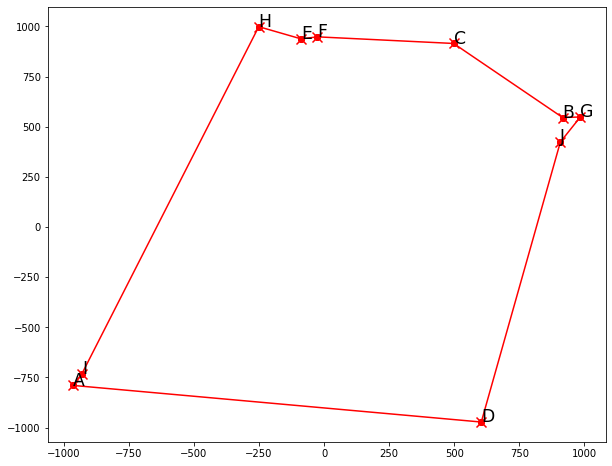

In [27]:
cities_no_A = list(cities_coords_2.keys())
cities_no_A.remove('A')
possible_paths = [list(L) for L in list(permutations(cities_no_A))]
possible_paths = [['A'] + L for L in possible_paths]

as_TSPNodes    = [TSPNode(state=p) for p in possible_paths]
total_dists    = [n.value() for n in as_TSPNodes]
path_dist_dict = dict(zip(total_dists,possible_paths))

min_dist = max(path_dist_dict.keys())
min_path = path_dist_dict[min_dist]

solutionTSP = TSPNode(state=min_path)
solutionTSP._distances=total_dists

print('Optimal result:',solutionTSP)
solution_visualization(solutionTSP, cities_coords_2)

### Detour -- Finding the best k and lambda

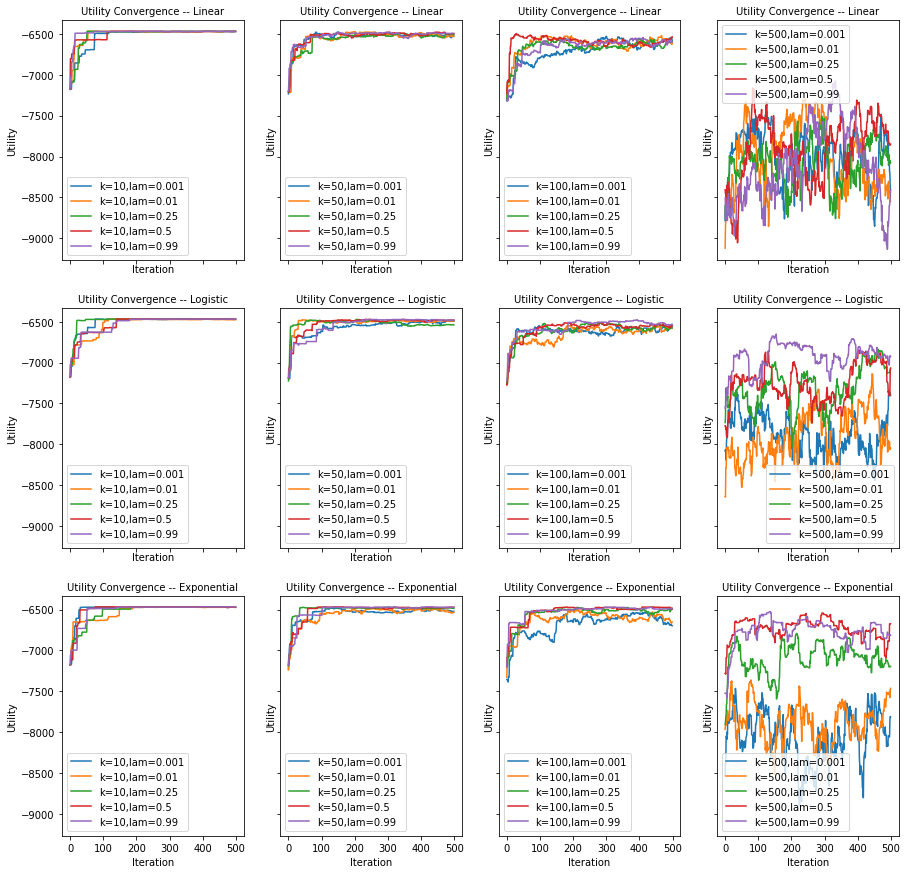

In [28]:
simulated_annealing_test([10,50,100,500],
                         [0.001,0.01,0.25,0.5,0.99],
                         initial_n_1,
                         1234,
                         trials=10,
                         name_sched_pairs=[('Linear',linear_schedule),
                                           ('Logistic',log_schedule),
                                           ('Exponential',exp_schedule)])

Utility converges most quickly when k=10 or k=50 -- with slightly more stability when k=50 for the linear and exponential schedules. With larger values of lambda -- particularly with the Logistic and Exponential schedules -- the patterns become more distinct, and we can observe that lower values of lambda outperform higher values.

### Exponential Schedule

In [29]:
max_iter,       num_trials,   rand_seed = 500, 15, 1234
k_set,          lam_set                 = [10,100], [0.1, 0.99]
res_dict_exp_1, data_exp_1,   sol_exp_1 = results(k_set,    lam_set,    exp_schedule,    rand_seed,
                                                  max_iter, num_trials, cities_coords_2, dist_mat_2, initial_n_1)
display(dict(zip(res_dict_exp_1.keys(),[v[0] for v in res_dict_exp_1.values()])))

{(10, 0.1): -6684.546622451529,
 (10, 0.99): -6467.877708018376,
 (100, 0.1): -6573.144732433278,
 (100, 0.99): -6576.2121652349515}

### Linear Schedule

In [30]:
# TODO: you need to decide the value set of k and lam by yourself

# I modified this code and instead used a res_dict function I created earlier.
# I also used the values of k and lambda determiend by the tests above.

max_iter,     num_trials, rand_seed     = 500, 15, 1234
k_set,        lam_set                   = [10,100], [0.1, 0.99]
res_dict_lin_1, data_lin_1,   sol_lin_1 = results(k_set,    lam_set,    linear_schedule,  rand_seed,
                                                  max_iter, num_trials, cities_coords_2,  dist_mat_2, initial_n_1)

display(dict(zip(res_dict_lin_1.keys(),[v[0] for v in res_dict_lin_1.values()])))

{(10, 0.1): -6576.212165234953,
 (10, 0.99): -6467.877708018377,
 (100, 0.1): -6533.482072203343,
 (100, 0.99): -6573.144732433276}

### Log Schedule

In [31]:
# TODO: you need to decide the value set of k and lam by yourself

# I modified this code and instead used a res_dict function I created earlier.
# I also used the values of k and lambda determiend by the tests above.

max_iter,     num_trials, rand_seed = 500, 15, 1234
k_set,        lam_set               = [10,100], [0.1, 0.99]
res_dict_log_1, data_log_1,   sol_log_1 = results(k_set,    lam_set,    log_schedule,    rand_seed,
                                                  max_iter, num_trials, cities_coords_2, dist_mat_2, initial_n_1)
display(dict(zip(res_dict_log_1.keys(),[v[0] for v in res_dict_log_1.values()])))

{(10, 0.1): -6467.877708018376,
 (10, 0.99): -6683.391969805659,
 (100, 0.1): -6553.181747384116,
 (100, 0.99): -6477.694136684019}

In [32]:
random_state = np.random.RandomState(seed=1234)

Exponential:
   Solution: [A, I, H, E, F, C, B, G, J, D]
   Optimal path found by at least one configuration of parameters: 136 iterations
   Approximate convergence by at least one configuration of parameters: 77 iterations
        k (approx. convergence):      10
        lambda (approx. convergence): 0.99
Linear:
   Solution: [A, I, H, E, F, C, B, G, J, D]
   Optimal path found by at least one configuration of parameters: 134 iterations
   Approximate convergence by at least one configuration of parameters: 65 iterations
        k (approx. convergence):      10
        lambda (approx. convergence): 0.1
Logarithmic:
   Solution: [A, I, H, E, F, C, B, G, J, D]
   Optimal path found by at least one configuration of parameters: 151 iterations
   Approximate convergence by at least one configuration of parameters: 101 iterations
        k (approx. convergence):      100
        lambda (approx. convergence): 0.1


<class 'list'>


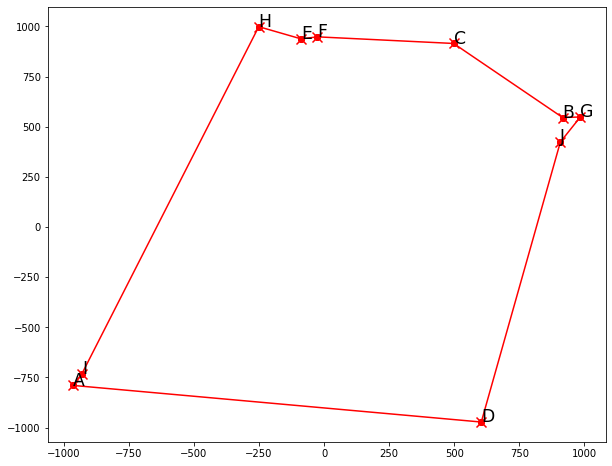

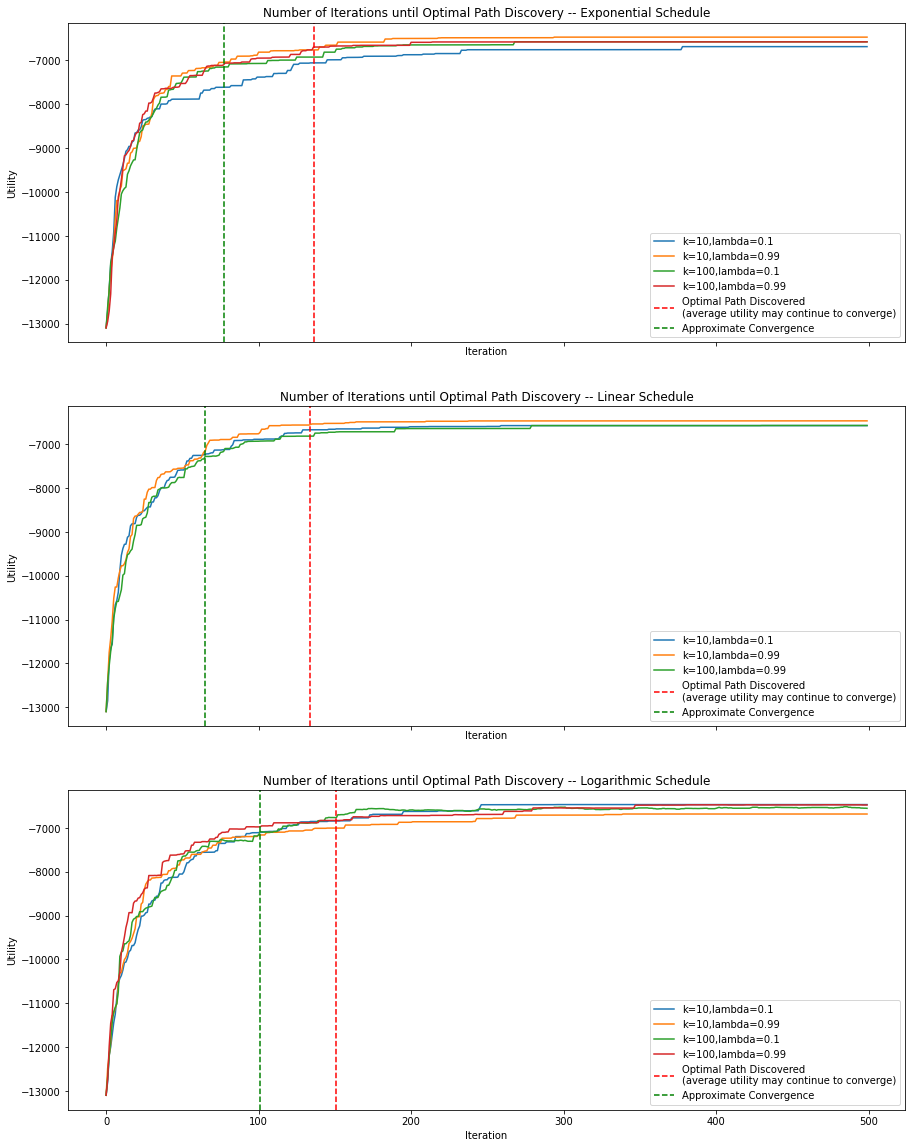

In [33]:
datas_1, dicts_1, solutions_1 = [data_exp_1,     data_lin_1,     data_log_1],\
                                [res_dict_exp_1, res_dict_lin_1, res_dict_log_1],\
                                [sol_exp_1,      sol_lin_1,      sol_log_1]

pretty_table_1, best_path_1, k_lam_list_1, first_iters_1, close_iters_1 = pretty_data(datas_1, solutions_1)

display(pretty_table_1)


## TSP-2 (Small cost)

The TSP problem generated with small costs. Please use your CWID as the random seed. 

In [34]:
num_city = 10
x_inner_range, x_outer_range = (-9, 9), (-15, 15)
y_inner_range, y_outer_range = (-9, 9), (-15, 15)

# TODO: Please replace "4321" with your own CWID number after "A"
your_own_seed = int("20452471")

cities_coords_3, dist_mat_3 = TSP_generator(your_own_seed, x_inner_range, x_outer_range, y_inner_range, y_outer_range, num_city)
tsp_graph_3 = make_graph(cities_coords_3, dist_mat_3)
TSPNode._distances = tsp_graph_3.distances

### Brute Force

Optimal result: Node: <A G D E C F J I H B> -98.2


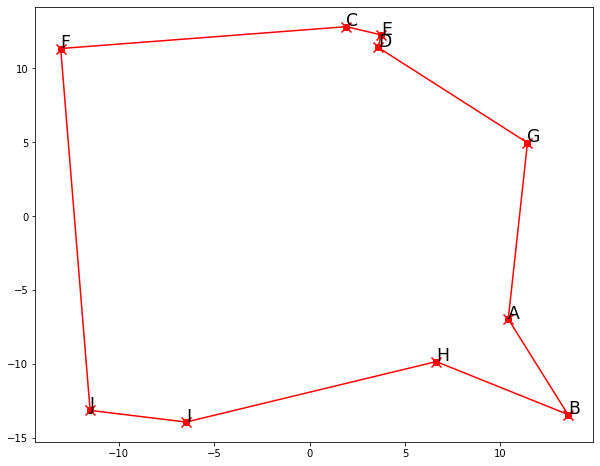

In [35]:
# TODO
# TODO Implement brute force search and record the optimal result and visualize it

### All possible paths

cities_no_A = list(cities_coords_3.keys())
cities_no_A.remove('A')
possible_paths = [list(L) for L in list(permutations(cities_no_A))]
possible_paths = [['A'] + L for L in possible_paths] 

as_TSPNodes    = [TSPNode(state=p) for p in possible_paths]
total_dists    = [n.value() for n in as_TSPNodes]
path_dist_dict = dict(zip(total_dists,possible_paths))

min_dist = max(path_dist_dict.keys())
min_path = path_dist_dict[min_dist]

solutionTSP = TSPNode(state=min_path)
solutionTSP._distances=total_dists

print('Optimal result:',solutionTSP)
solution_visualization(solutionTSP, cities_coords_3)

### Choosing k & lambda

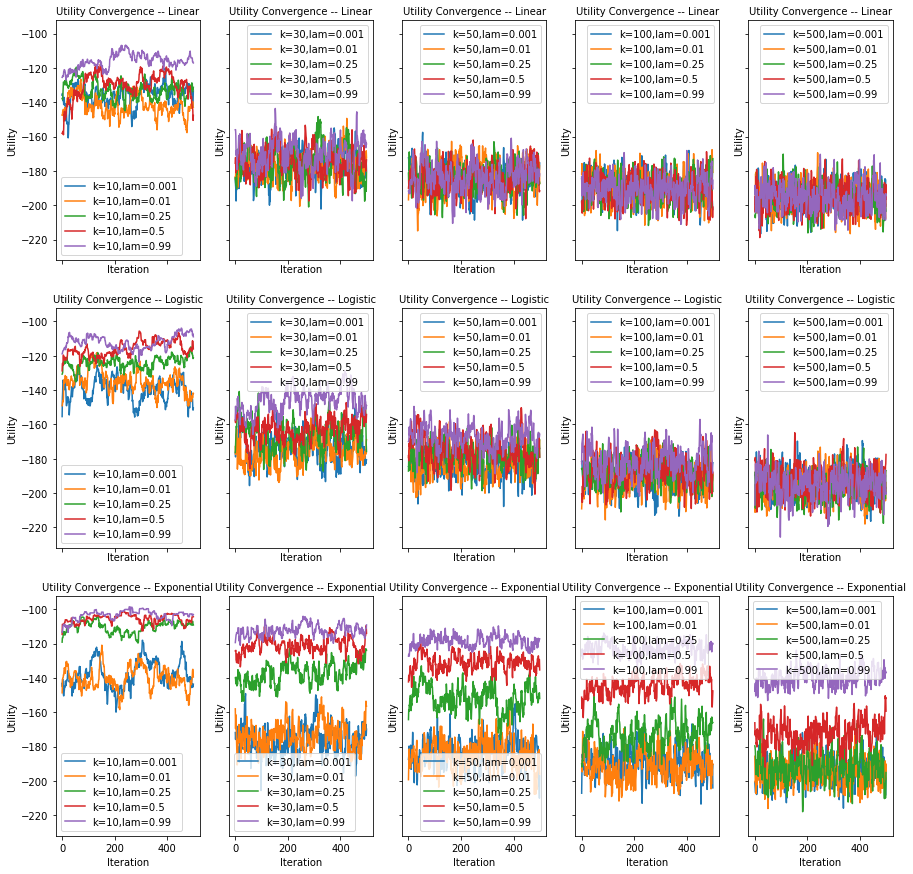

In [37]:
### Choosing k and lam
initial_n_2 = init_state(20452471,cities_coords_3)
simulated_annealing_test([10,30,50,100,500],[0.001,0.01,0.25,0.5,0.99],initial_n_2,20452471,trials=10, name_sched_pairs=[('Linear',linear_schedule),('Logistic',log_schedule),('Exponential',exp_schedule)])

Once again, the algorithm performs best with lowers values of and higher values of lambda. However, compared to the larger data, the cost stays relatively constant within any given configuration of temperature schedule, k, and lambda -- i.e., it doesn't converge.

### Exponential Schedule

In [38]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter, num_trials, rand_seed       = 500, 10, your_own_seed
k_set,    lam_set                     = [10,100], [0.1, 0.99]
res_dict_exp_2, data_exp_2, sol_exp_2 = results(k_set,    lam_set,    exp_schedule,    rand_seed,
                                                max_iter, num_trials, cities_coords_3, dist_mat_3,  initial_n_2)
display(dict(zip(res_dict_exp_2.keys(),[v[0] for v in res_dict_exp_2.values()])))

{(10, 0.1): -98.23639866968088,
 (10, 0.99): -98.23639866968092,
 (100, 0.1): -101.84673745211214,
 (100, 0.99): -98.23639866968092}

### Linear Schedule

In [39]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter, num_trials, rand_seed = 500, 10, your_own_seed
k_set,        lam_set           = [10,100], [0.1, 0.99]
res_dict_lin_2, data_lin_2, sol_lin_2 = results(k_set,    lam_set,    linear_schedule, rand_seed,
                                                max_iter, num_trials, cities_coords_3, dist_mat_3,  initial_n_2)
display(dict(zip(res_dict_lin_2.keys(),[v[0] for v in res_dict_lin_2.values()])))

{(10, 0.1): -98.2363986696809,
 (10, 0.99): -98.23639866968091,
 (100, 0.1): -177.01244117331524,
 (100, 0.99): -98.2363986696809}

### Log Schedule

In [40]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter, num_trials, rand_seed = 500, 10, your_own_seed
k_set,        lam_set           = [10,100], [0.1,0.99]
res_dict_log_2, data_log_2, sol_log_2 = results(k_set,    lam_set,    log_schedule,    rand_seed,
                                                max_iter, num_trials, cities_coords_3, dist_mat_3,  initial_n_2)
display(dict(zip(res_dict_log_2.keys(),[v[0] for v in res_dict_log_2.values()])))

{(10, 0.1): -122.20080912799067,
 (10, 0.99): -99.48382256667973,
 (100, 0.1): -187.5454302931661,
 (100, 0.99): -154.34354579088603}

In [41]:
# TODO: Present a table of your results for TSP-2. Consider using pandas.

Exponential:
   Solution: [A, G, D, E, C, F, J, I, H, B]
   Optimal path found by at least one configuration of parameters: 119 iterations
   Approximate convergence by at least one configuration of parameters: 98 iterations
        k (approx. convergence):      100
        lambda (approx. convergence): 0.99
Linear:
   Solution: [A, G, D, E, C, F, J, I, H, B]
   Optimal path found by at least one configuration of parameters: 87 iterations
   Approximate convergence by at least one configuration of parameters: 92 iterations
        k (approx. convergence):      10
        lambda (approx. convergence): 0.99
Logarithmic:
   Solution: [A, G, E, D, C, F, J, I, H, B]
   Optimal path found by at least one configuration of parameters: 174 iterations
   Approximate convergence by at least one configuration of parameters: 94 iterations
        k (approx. convergence):      10
        lambda (approx. convergence): 0.99


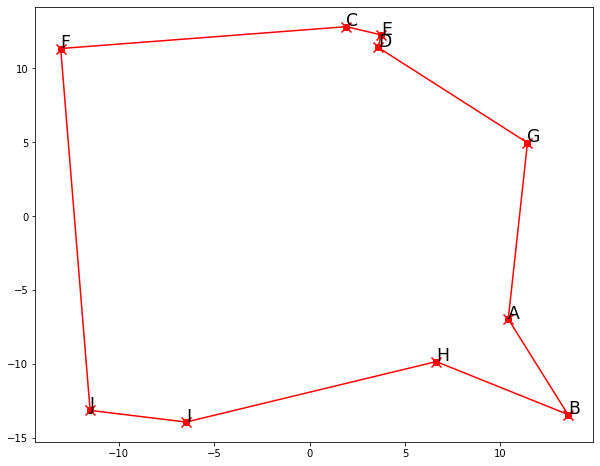

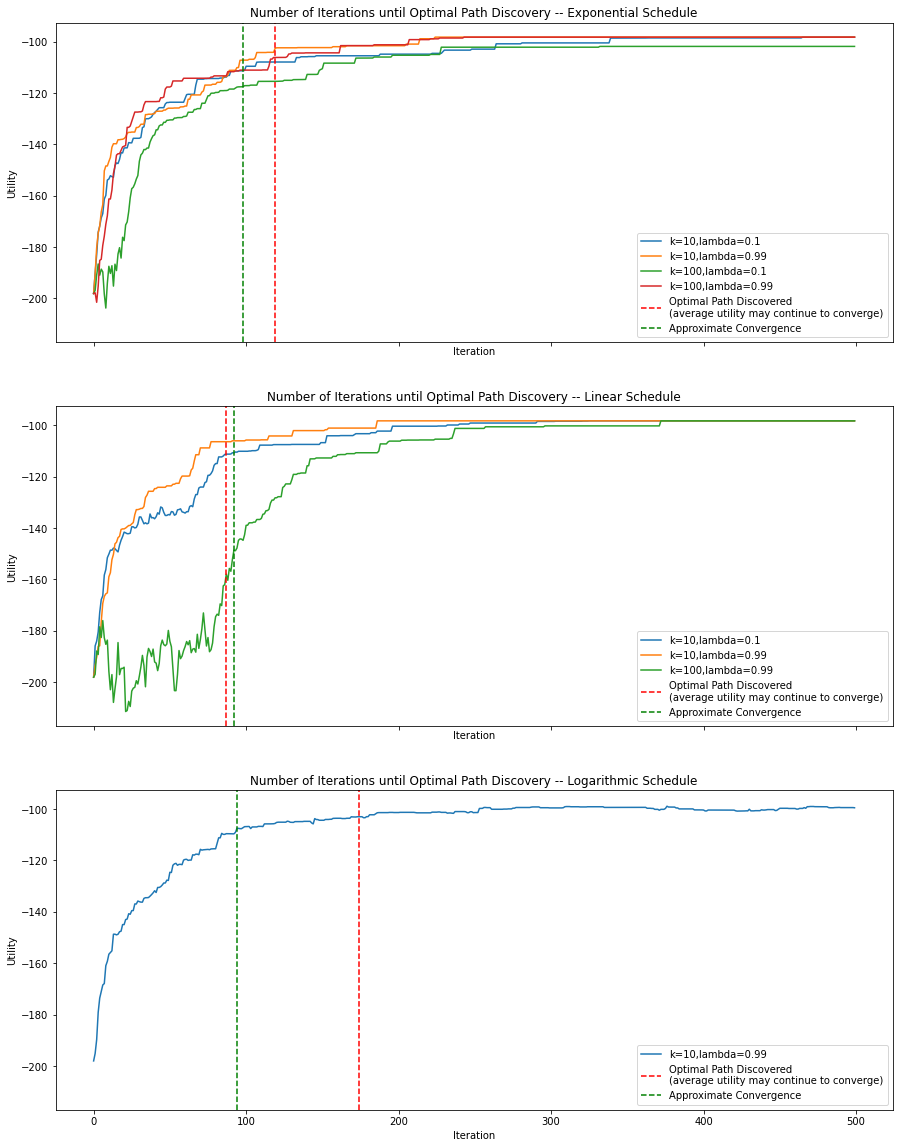

In [42]:
datas_2, dicts_2, solutions_2 = [data_exp_2,     data_lin_2,     data_log_2],\
                                [res_dict_exp_2, res_dict_lin_2, res_dict_log_2],\
                                [sol_exp_2,      sol_lin_2,      sol_log_2]

pretty_table_2, best_path_2, k_lam_list_2, first_iters_2, close_iters_2 = pretty_data(datas_2, solutions_2)

display(pretty_table_2)

## TSP-3 (berlin52)

The TSP problem loaded from the file "berlin52.tsp" with 52 cities.

In [44]:
cities_coords_4, dist_mat_4 = read_TSP_from_file()
tsp_graph_4 = make_graph(cities_coords_4, dist_mat_4)
TSPNode._distances = tsp_graph_4.distances

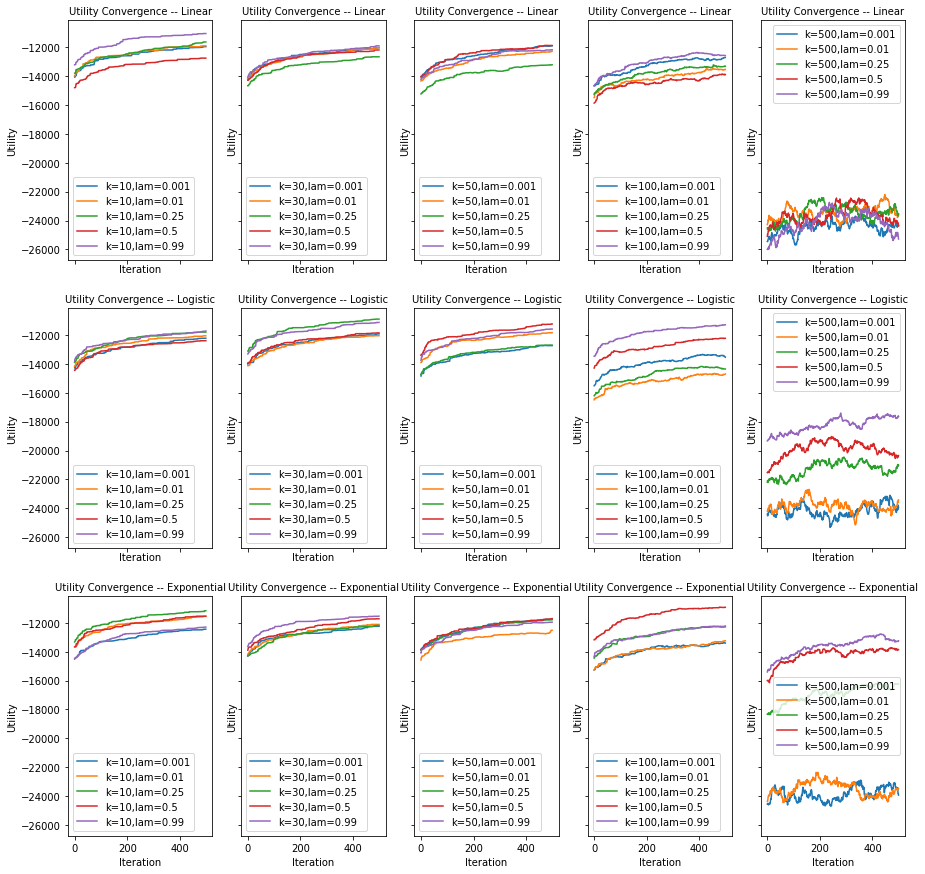

In [46]:
### Choosing k and lambda
initial_n_3 = init_state(1234,cities_coords_4)
simulated_annealing_test([10,30,50,100,500],[0.001,0.01,0.25,0.5,0.99],initial_n_3,20452471,trials=10, name_sched_pairs=[('Linear',linear_schedule),('Logistic',log_schedule),('Exponential',exp_schedule)])

With this data, the algorithm seems to perform best at k=10 and lambda=0.5, so we will keep the range of values around those numbers.

### Exponential Schedule

In [47]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter,       num_trials, rand_seed = 500, 10, 1234
k_set,          lam_set               = [10,20], [0.25, 0.5, 0.75]
res_dict_exp_3, data_exp_3, sol_exp_3 = results(k_set,    lam_set,    exp_schedule,    rand_seed,
                                                max_iter, num_trials, cities_coords_4, dist_mat_4,  initial_n_3)
display(dict(zip(res_dict_exp_3.keys(),[v[0] for v in res_dict_exp_3.values()])))

{(10, 0.25): -15319.3104441367,
 (10, 0.5): -15470.437179440947,
 (10, 0.75): -15237.91202847534,
 (20, 0.25): -15520.121032171863,
 (20, 0.5): -15292.956360487247,
 (20, 0.75): -15365.148483619696}

### Linear Schedule

In [48]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter,       num_trials, rand_seed = 500, 10, 1234
k_set,          lam_set               = [10,20], [0.25, 0.5, 0.75]
res_dict_lin_3, data_lin_3, sol_lin_3 = results(k_set,    lam_set,    linear_schedule, rand_seed,
                                                max_iter, num_trials, cities_coords_4, dist_mat_4,  initial_n_3)
display(dict(zip(res_dict_lin_3.keys(),[v[0] for v in res_dict_lin_3.values()])))

{(10, 0.25): -15303.713233959375,
 (10, 0.5): -15910.298391288143,
 (10, 0.75): -15385.933230050598,
 (20, 0.25): -15502.052336074883,
 (20, 0.5): -16119.381743795791,
 (20, 0.75): -15054.571008915265}

### Log Schedule

In [49]:
# I modified this code and instead used a res_dict function from the helper file.

max_iter,       num_trials, rand_seed = 500, 10, 1234
k_set,          lam_set               = [10,20], [0.25, 0.5, 0.75]
res_dict_log_3, data_log_3, sol_log_3 = results(k_set,    lam_set,    log_schedule,    rand_seed,
                                                max_iter, num_trials, cities_coords_4, dist_mat_4,  initial_n_3)
display(dict(zip(res_dict_log_3.keys(),[v[0] for v in res_dict_log_3.values()])))

{(10, 0.25): -15421.424711250427,
 (10, 0.5): -15142.599986842024,
 (10, 0.75): -15973.704358661882,
 (20, 0.25): -15416.948781959329,
 (20, 0.5): -15408.35305528594,
 (20, 0.75): -15723.294504568936}

In [50]:
# TODO: Present a table of your results for TSP-3. Consider using pandas.

In [53]:
datas_3, dicts_3, solutions_3 = [data_exp_3,     data_lin_3,     data_log_3],\
                                [res_dict_exp_3, res_dict_lin_3, res_dict_log_3],\
                                [sol_exp_3,      sol_lin_3,      sol_log_3]

pretty_table_3, best_path_3, k_lam_list_3, first_iters_3, close_iters_3 = pretty_data(datas_3, solutions_3)
display(pretty_table_3)

Exponential:
   Solution: [1, 4, 11, 12, 15, 6, 38, 24, 40, 42, 7, 2, 30, 44, 46, 51, 33, 35, 31, 22, 45, 3, 17, 21, 34, 18, 23, 39, 37, 50, 16, 20, 43, 10, 9, 8, 41, 19, 29, 26, 47, 13, 48, 5, 28, 27, 14, 52, 25, 36, 49, 32]
   Optimal path found by at least one configuration of parameters: 500 iterations
   Approximate convergence by at least one configuration of parameters: 394 iterations
        k (approx. convergence):      10
        lambda (approx. convergence): 0.75
Linear:
   Solution: [1, 22, 35, 37, 32, 18, 3, 7, 2, 30, 42, 17, 21, 23, 31, 45, 8, 28, 27, 4, 12, 13, 52, 14, 47, 9, 10, 41, 33, 25, 51, 11, 6, 15, 5, 39, 48, 38, 43, 24, 46, 26, 29, 50, 34, 40, 36, 16, 20, 19, 49, 44]
   Optimal path found by at least one configuration of parameters: 500 iterations
   Approximate convergence by at least one configuration of parameters: 395 iterations
        k (approx. convergence):      20
        lambda (approx. convergence): 0.75
Logarithmic:
   Solution: [1, 32, 22, 2, 7, 30,

# Report

### Across datasets and cost structures, the algorithm performed best with lower levels of k and higher levels of lambda.


### Large Costs:

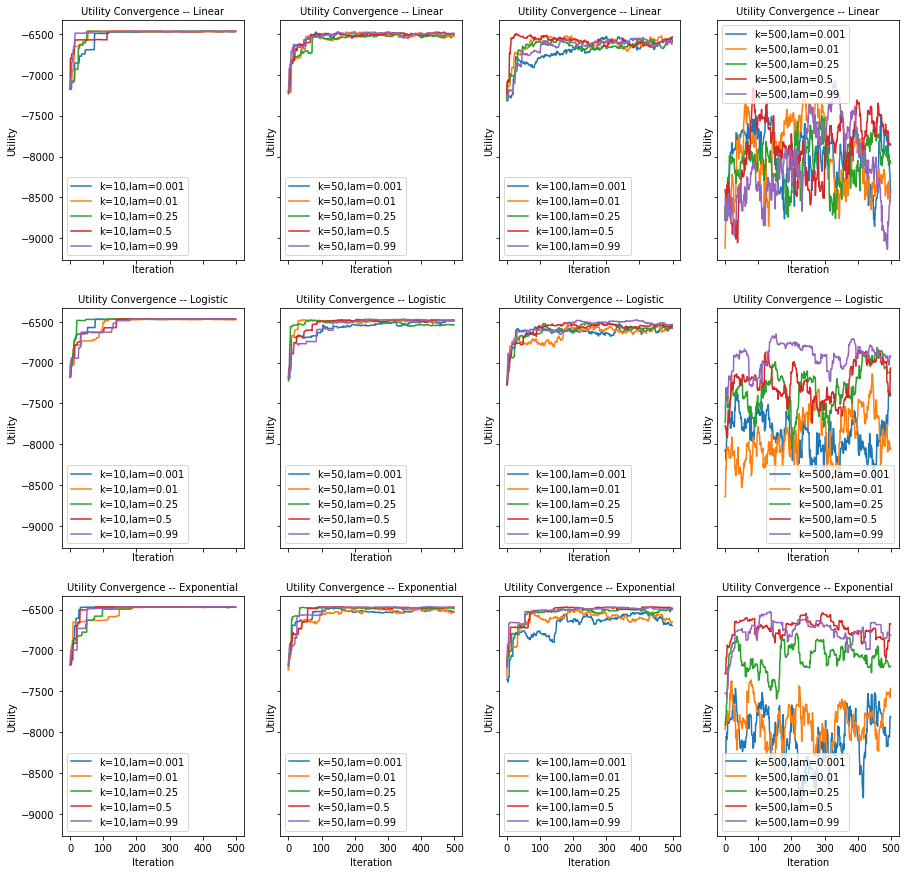


### Small Costs:

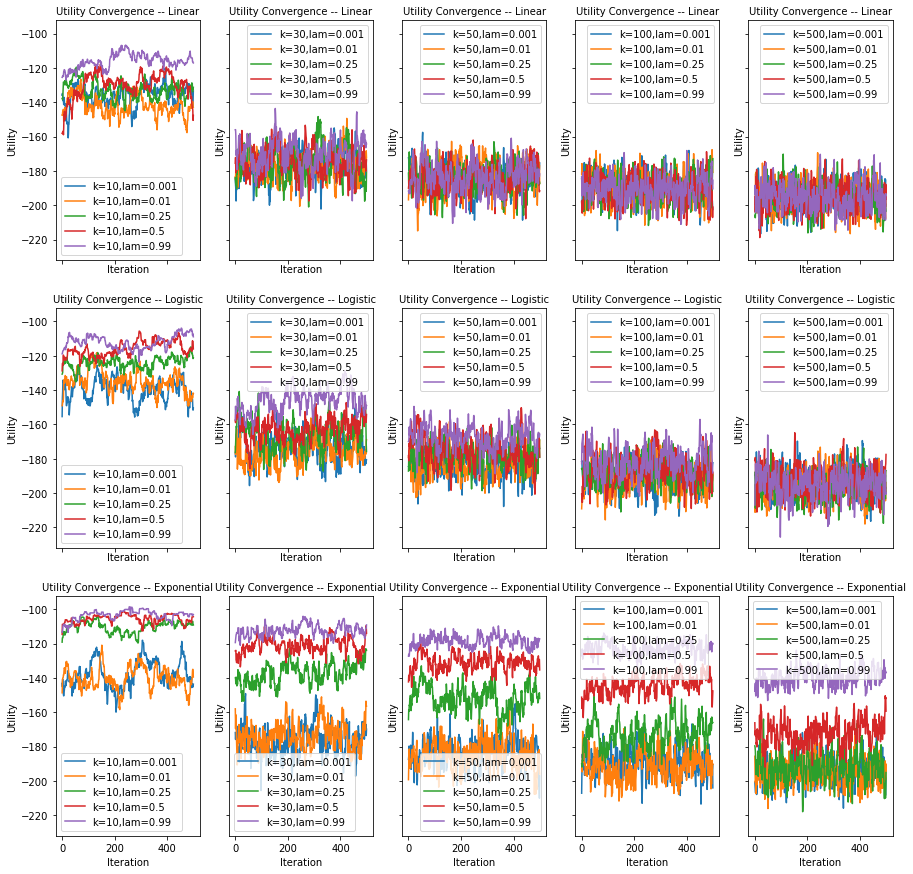

### Berlin Dataset:

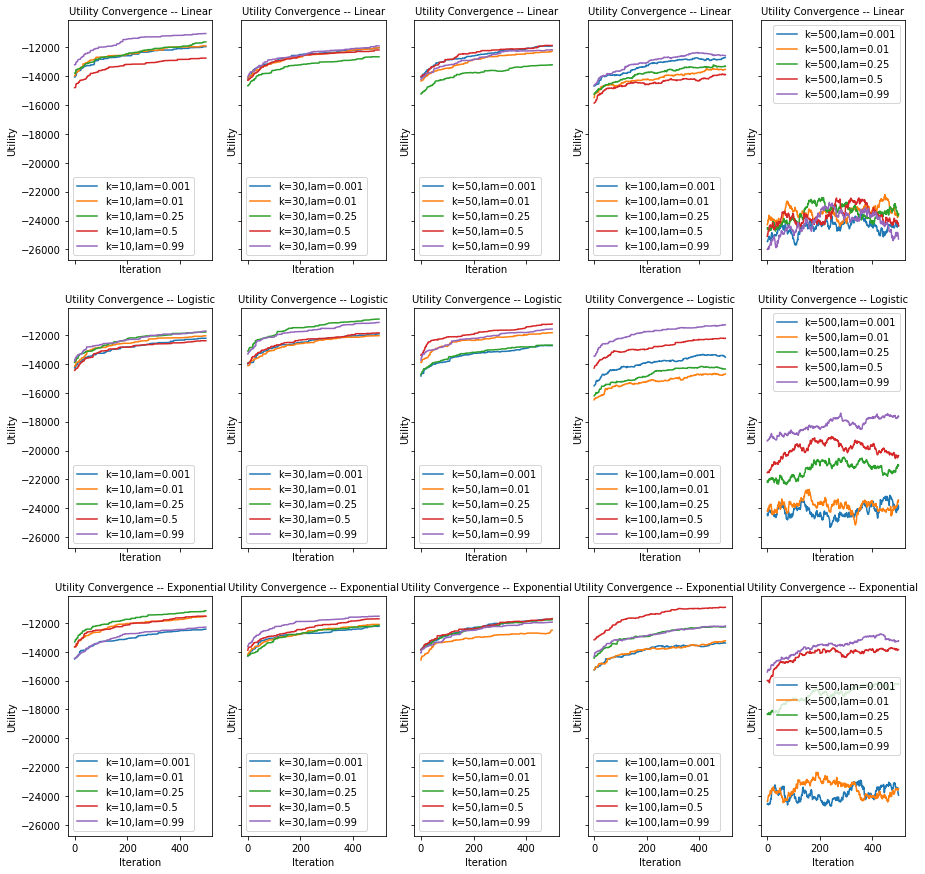


### The algorithm succeeded at finding reasonable best paths when there were fewer cities. The results were more chaotic with the Berlin dataset.

Large costs


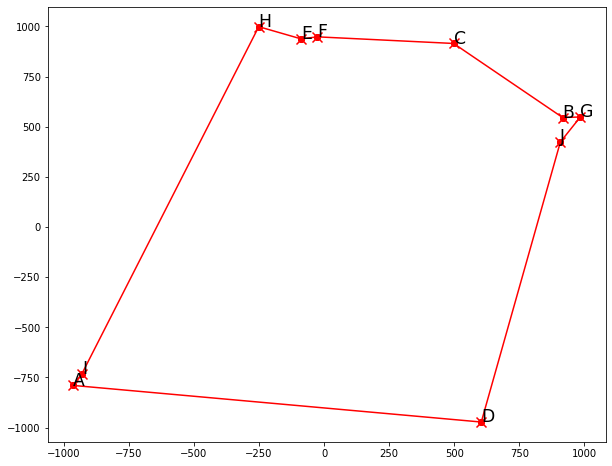

Small costs


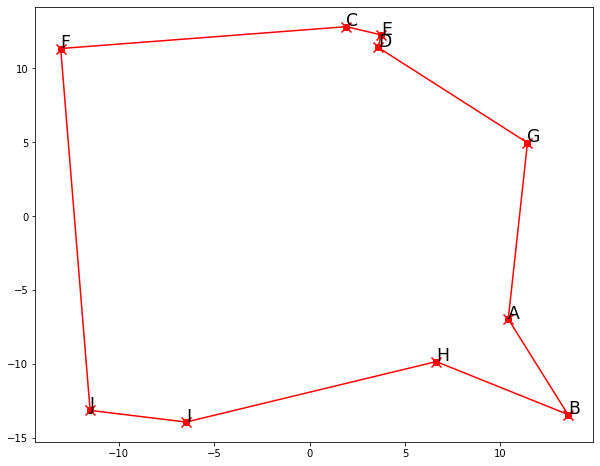

Berlin data


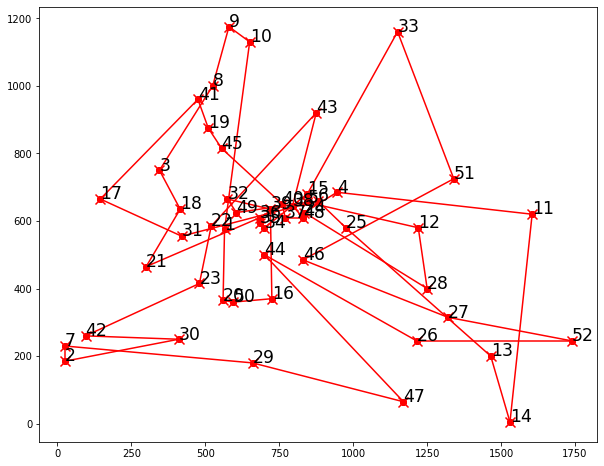

In [58]:
print('Large costs')
solution_visualization(TSPNode(state = best_path_1),cities_coords_2)  
plt.show()
print('Small costs')
solution_visualization(TSPNode(state = best_path_2),cities_coords_3) 
plt.show()
print('Berlin data')
solution_visualization(TSPNode(state = best_path_3),cities_coords_4)  
plt.show()

### The data converged reasonably well with the datasets with fewer cities, but not with the berlin dataset. Plotting utility confirms my findings that small k and large lambas performed best.

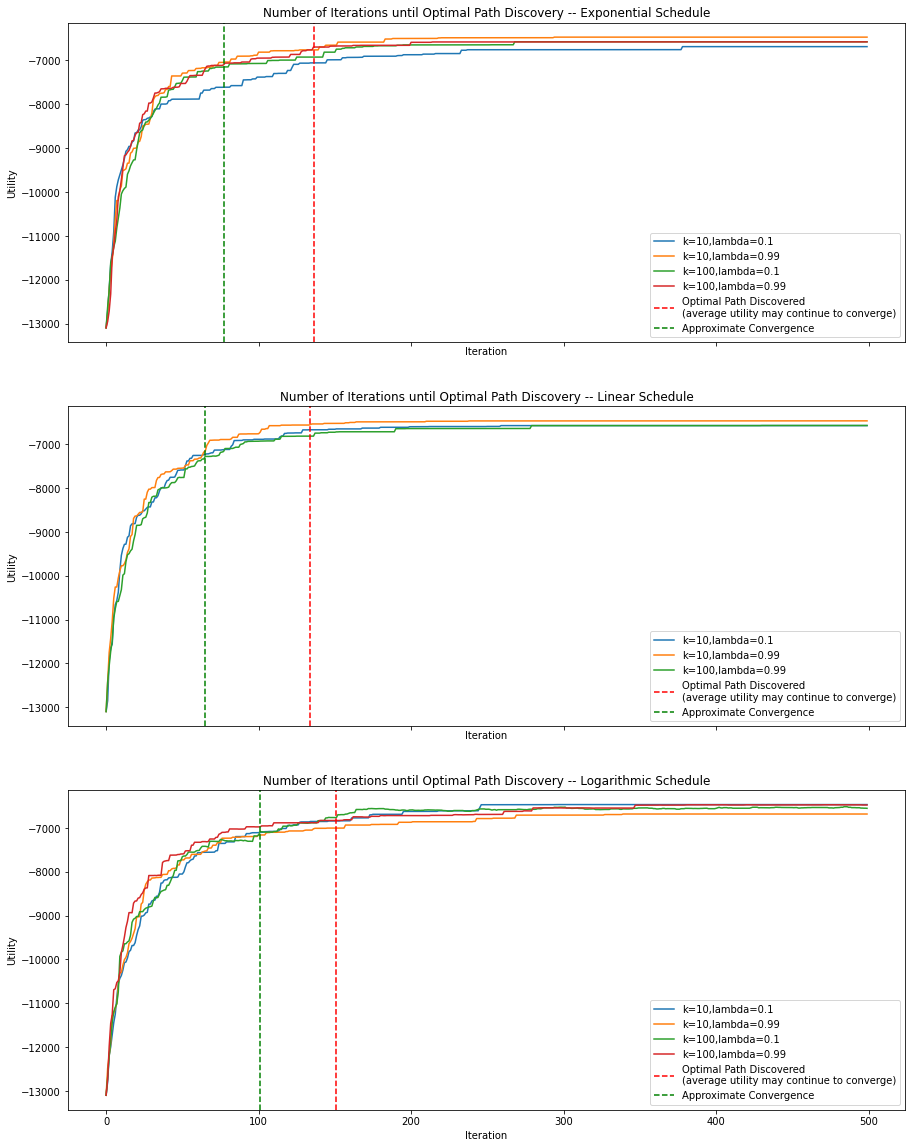

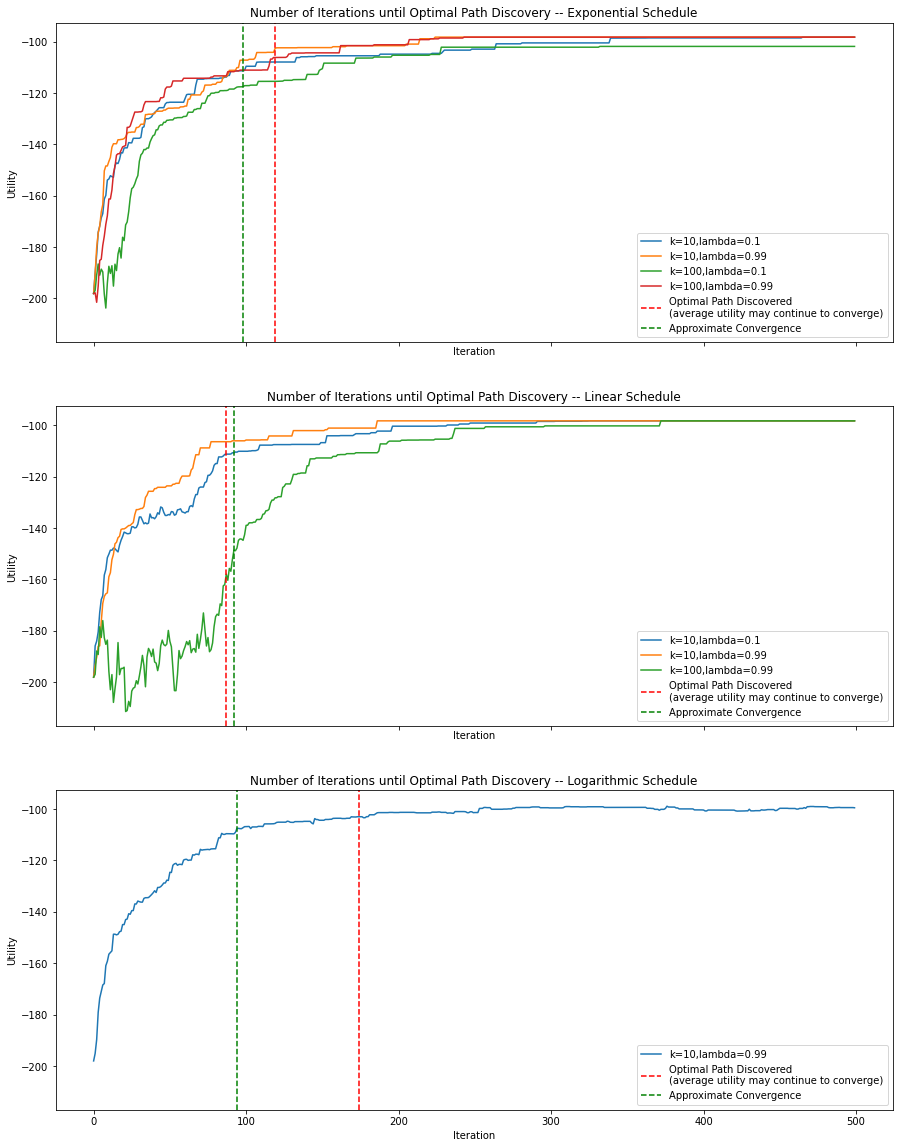

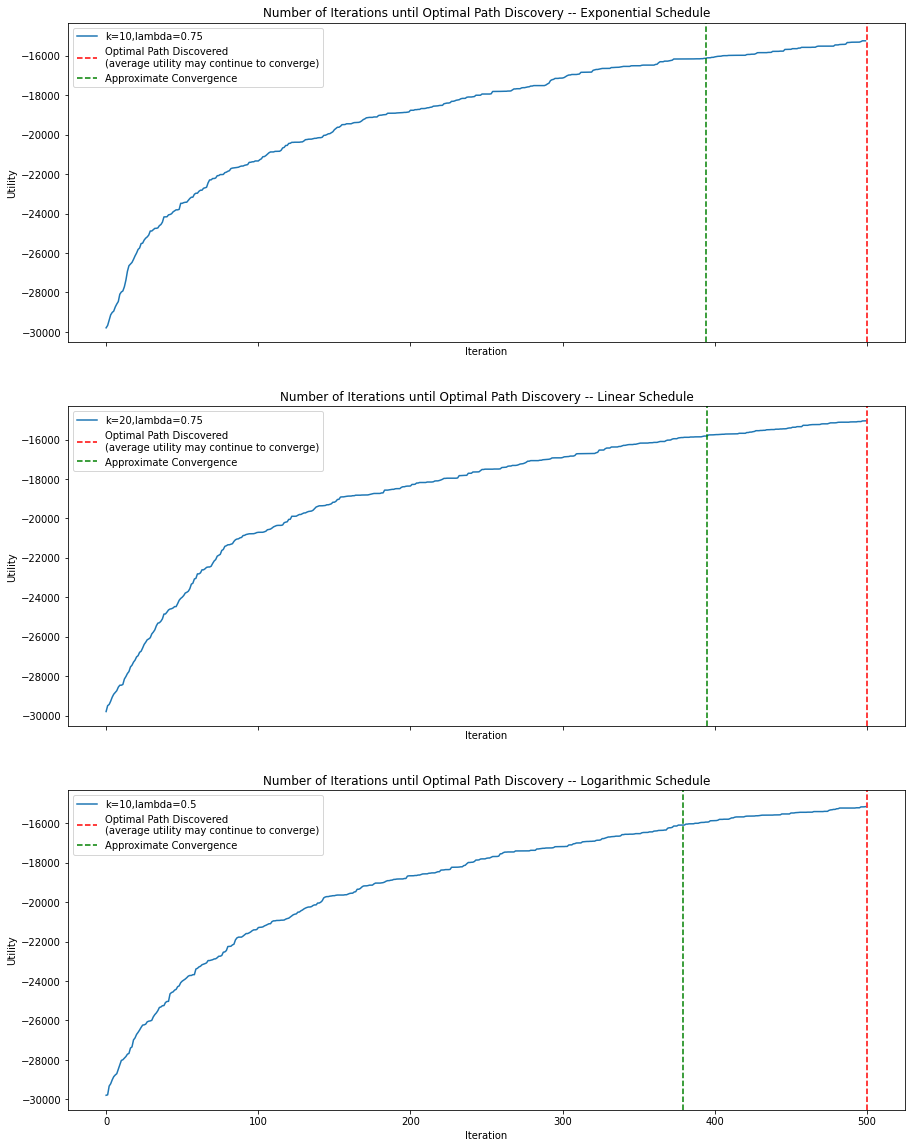

In [59]:
plot_utility(dicts_1,k_lam_list_1,first_iters_1,close_iters_1,initial_n_1)
plt.show()
plot_utility(dicts_2,k_lam_list_2,first_iters_2,close_iters_2,initial_n_2)
plt.show()
plot_utility(dicts_3,k_lam_list_3,first_iters_3,close_iters_3,initial_n_3)
plt.show()